# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

For this assignment, you will use reinforcement learning to solve the [Towers of Hanoi](https://en.wikipedia.org/wiki/Tower_of_Hanoi) puzzle.  

To accomplish this, you must modify the code discussed in lecture for learning to play Tic-Tac-Toe.  Modify the code  so that it learns to solve the three-disk, three-peg
Towers of Hanoi Puzzle.  In some ways, this will be simpler than the
Tic-Tac-Toe code.  

Steps required to do this include the following:

  - Represent the state, and use it as a tuple as a key to the Q dictionary.
  - Make sure only valid moves are tried from each state.
  - Assign reinforcement of $1$ to each move, even for the move that results in the goal state.

Make a plot of the number of steps required to reach the goal for each
trial.  Each trial starts from the same initial state.  Decay epsilon
as in the Tic-Tac-Toe code.

## Requirements

First, how should we represent the state of this puzzle?  We need to keep track of which disks are on which pegs. Name the disks 1, 2, and 3, with 1 being the smallest disk and 3 being the largest. The set of disks on a peg can be represented as a list of integers.  Then the state can be a list of three lists.

For example, the starting state with all disks being on the left peg would be `[[1, 2, 3], [], []]`.  After moving disk 1 to peg 2, we have `[[2, 3], [1], []]`.

To represent that move we just made, we can use a list of two peg numbers, like `[1, 2]`, representing a move of the top disk on peg 1 to peg 2.

Now on to some functions. Define at least the following functions. Examples showing required output appear below.

   - `printState(state)`: prints the state in the form shown below
   - `validMoves(state)`: returns list of moves that are valid from `state`
   - `makeMove(state, move)`: returns new (copy of) state after move has been applied.
   - `trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF)`: train the Q function for number of repetitions, decaying epsilon at start of each repetition. Returns Q and list or array of number of steps to reach goal for each repetition.
   - `testQ(Q, maxSteps, validMovesF, makeMoveF)`: without updating Q, use Q to find greedy action each step until goal is found. Return path of states.

A function that you might choose to implement is

   - `stateMoveTuple(state, move)`: returns tuple of state and move.  
    
This is useful for converting state and move to a key to be used for the Q dictionary.

Show the code and results for testing each function.  Then experiment with various values of `nRepetitions`, `learningRate`, and `epsilonDecayFactor` to find values that work reasonably well, meaning that eventually the minimum solution path of seven steps is found consistently.

Make a plot of the number of steps in the solution path versus number of repetitions. The plot should clearly show the number of steps in the solution path eventually reaching the minimum of seven steps, though the decrease will not be monotonic.  Also plot a horizontal, dashed line at 7 to show the optimal path length.

Add markdown cells in which you describe the Q learning algorithm and your implementation of Q learning as applied to the Towers of Hanoi problem.  Use at least 15 sentences, in one or more markdown cells.

## Printing and Formatting
Code in this section provides a readable format of the towers of hanoi state and a tuple utility function.

The method `printState` prints out a representation of the state of the towers of hanoi puzzle. As and example, the state [[1,2,3],[],[]], which is the starting state, would return:
```
1 
2
3
------
```
To create this representation, a new copy of the state is made to leave the original intact. Then each list in the state is filled with space characters so they each have equal length. Finally, the i'th element of each list is printed in column format.

In [4]:
import copy as cp
#Prints based on how many rows there are.
def printState(state):
    #Deep copy ensures each inner list is also copied into a new list.
    printState = cp.deepcopy(state)
    for s in printState:
        while len(s) < 3:
            s.insert(0, " ")
    for i in range(3):
        print(printState[0][i],printState[1][i],printState[2][i], sep = " ")
    print("-----")

This method returns a tuple pair of the provided state and move. In the Q dicionary, the values are stored based on their `(state,move)` key. This helper function makes each list in state into a tuple, then makes the move list into a tuple and returns both of them as a pair. 

In [5]:
def stateMoveTuple(state, move):
    statetup = tuple([tuple(l) for l in state])
    movetup = tuple(move)
    return(statetup, movetup)

## Manipulating state of the puzzle
Code in this section provides methods of finding changing the puzzle in a way that is consistent with the constraints of the towers of hanoi. 

This function will return a new state given a state and move that reflects the given move on that state. `state` is the list representation of the puzzle discussed above. `move` is a list of length 2 where the first element is the peg to move from and the second element is the peg to move too. So `move = [1,2]` would indicate moving the disk on top of peg 1 to peg 2. 

First, `state` is copied into `newState` so that `state` is left intact. Then `disk`, representing the disk being moved from peg to peg, is poped of the first member of `move`. Finally, `disk` is inserted at the front of the destination list, placing it ontop of the peg stack. The only slight complication is that peg indexes must be adjusted from their move represenation. So a move from peg 1 to peg 2 must access `state[0]` and `state[1]`.

The method assumes that the given move is valid, so it could fail on incorrect input.

In [6]:
import copy as cp
def makeMove(state, move):
    newState = cp.deepcopy(state)
    disk = newState[move[0] - 1].pop(0)
    newState[move[1] - 1].insert(0, disk)
    return newState

This method is a helper method to the following method `validMoves`. Given a `state`, index `i` and index `j`, it determines whether the state has a disk at that index. This is a common check in `validMoves`. 

In [7]:
def nullCheck(state, i, j):
    if len(state) > i and len(state[i]) > j:
        return True
    else:
        return False

This method determines the valid moves from a given `state` following the rules of the towers of hanoi puzzle. The only restriction in the puzzle is that a disk cannot be moved onto a smaller disk. In our representation, this means that an int cannot be moved into another list in `state` where the following int in the destination list is greater. 

The method breaks the valid moves into three sections, one for each source peg. So the first line `if nullCheck(state, 0, 0):` determines all valid moves from the first peg given `state`. Then the inner if statements check for the status of the other two pegs. For example, the line `if not nullCheck(state, 1, 0) or state[0][0] < state[1][0]:` checks if the move from peg 1 to peg 2 is valid by checking to see if peg 2 is empty, in which case the move is valid by default, or the top disk on peg two is less than the source disk. After looking at each possible move in this manner, all valid moves are returned.

In [8]:
def validMoves(state):
    retList = []
    #Pretty much just going to check each possible move. 
    #Don't see an easier way to do it, or a reason why. 
    if nullCheck(state, 0, 0):
        if not nullCheck(state, 1, 0) or state[0][0] < state[1][0]:
            retList.append([1,2])
        if not nullCheck(state, 2, 0) or state[0][0] < state[2][0]:
            retList.append([1,3])
    if nullCheck(state, 1, 0):
        if not nullCheck(state, 0, 0) or state[1][0] < state[0][0]:
            retList.append([2,1])
        if not nullCheck(state, 2, 0) or state[1][0] < state[2][0]:
            retList.append([2,3])
    if nullCheck(state, 2, 0):
        if not nullCheck(state, 0, 0) or state[2][0] < state[0][0]:
            retList.append([3,1])
        if not nullCheck(state, 1, 0) or state[2][0] < state[1][0]:
            retList.append([3,2])
    return retList

## Training and Using Q
Code in this section builds and tests the Q dictionary. Q is a dictionary where the value for a `(state, move)` tuple is an estimation of the remaining moves to get to the goal. 

Here is the method `epsionGreedy` which takes an epsilon, Q dictionary and state. `epsilon` represents the probability that we take the random choice. First, the method gets a valid list of moves based on `state`. Then, if a random number between 1 and 0 is less than epsilon, a random choice from that list is returned. Otherwise, the move with the highest value in `Q` is returned, representing the greedy choice. In this case, we represent unseen moves with 0 using the `get` function so that further exploration is encouraged.

In [9]:
import numpy as np
def epsilonGreedy(epsilon, Q, state):
    moveList = validMoves(state)
    if np.random.uniform() < epsilon:
        #This is the random move, just choose one of our valid moves
        choice = np.random.choice(range(len(moveList)))
        return moveList[choice]
    else:
        # Use our Q function to greedily pick the next move. 
        statesAndMovesTuples = [stateMoveTuple(state, move) for move in moveList]
        #Theoretically, we want to choose the lowest Q, so if we haven't seen it
        #assume that it isn't good: its value is inf. 
        #This is reflected in choosing argmin, not argmax. 
        Qs = np.array([Q.get(tup, 0) for tup in statesAndMovesTuples])
        return moveList[np.argmin(Qs)]

This method trains the Q dictionary based. The parameters are:
- `nRepetitions`. Controls the outer loop. Effects run time and accuracy of Q dictionary. 
- `learningRate`. Changes how quickly values in `Q` learn.
- `validMovesF` A function that returns a list of valid moves. 
- `makeMoveF` A function that makes a move and returns a copy of the given state. 
- `showMoves = False` A default initialized variable that I added for the shareMoves functionality.

First, a few variables are initialized. `Q` is initialized to an empty dictionary, `numberSteps` is an empty list to store each trials number of steps to find the goal, and `epsilon` is set to 1. 

Then trials are ran for `nRepetitions`. `epsilon` is decayed by `epsilonDecayFactor` for each trial so that the randomness of the choices given by `epsilonGreedy` decreases over time. More variables are initialized at the beginning of the trial to keep track of steps, create the starting state and say when the trail is done. 

The inner loop then executes until the goal state `[[],[],[1,2,3]]` is found. At each iteration 
- `step` is incremented to represent the number of moves taken to find the goal
- `move` is set using `epsilonGreedy` to pick a valid move. 
- `newState` is made using `makeMoveF`. This represents the new step along this path that the algorithm is taking.
- `Tup` and `newTup` are made for easy reference. 
- If the current (state, move) tuple is not in `Q`, then we initialize that value to zero. Initially the remaining steps to the goal are unknow, and because they will be added to overtime 0 is a reasonable value for initialization.
- If the goal state has been reached, set `Q[state,move]` to one. This is we know that at this point only one step remains to the goal. `Q[newState, move]` is set to zero because no steps remain to get to the goal from here. 
- Otherwise if on the second iteration or more, the value for `Q[(oldState, moveOld)]` is updated using the temporal difference update. `oldState` and `moveOld` come from the last lines of the loop and represent the pair from the last iteration, which we can now say something about because of the new move. `learningRate` is multiplied by the reinforcement 1, representing the step cost, plus the difference between `Q[(state, move)]` and `Q[(oldState, moveOld)]`. This updates the Q value of `(stateOld, moveOld)` over time depending on `learningRate` so that it can learn over time and not to quickly while using the difference to inform the error. 
- Finally, `stateOld` and `moveOld` are set to `state` and `move` respectively. This is so the next iteration can look back on the old state of the puzzle to update what it found about the current move. `state` is updated in a similar way. 

In [10]:
def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF, showMoves = False):
    Q = {}
    #Dictionary to represent our Q function. 
    #MakeTuple of the state can get the unique value.
    numberSteps = []
    epsilon = 1.0
    for trial in range(nRepetitions):
        epsilon *= epsilonDecayFactor
        step = 0
        state = [[1,2,3],[],[]] #Default starting state.
        done = False
        
        while not done:
            step += 1 #not sure what this does. Reinforcement?
            #choose a move from the current state
            move = epsilonGreedy(epsilon, Q, state)
            #make a new state from the greedy move.
            newState = makeMoveF(state, move)
           
            #if showMoves:
            #    printState(newState)
            Tup = stateMoveTuple(state, move)
            newTup = stateMoveTuple(newState, move)
            #print(step, newTup)
            if Tup not in Q:
                Q[Tup] = 0 #initiallizes unseen Qs
            
            if newState == [[],[],[1,2,3]]: #this means we found the solution.
                if showMoves:
                    print("Found solution in " + str(step))
                Q[Tup] = 1
                Q[newTup] = 0
                done = True
                numberSteps.append(step)
                
            #Do not need the move for O like in tic tac toe, because this is not adversarial.
            
            if step > 1: #Don't do this on first step, got it. 
                #Also, old state and move are set in the first term, so other we can reference them here.
                #Q[(tuple(boardOld),moveOld)] += rho * (Q[(tuple(board),move)] - Q[(tuple(boardOld),moveOld)])
                #print(step, newTup)
                #print(stateMoveTuple(stateOld, moveOld))
                Q[(stateMoveTuple(stateOld, moveOld))] += learningRate * (1 + Q[Tup] -
                                                                         Q[stateMoveTuple(stateOld, moveOld)])
            
            #set old variables
            stateOld, moveOld = state, move
            state = newState
    return Q, numberSteps
            

`testQ` validates the Q dictionary by choosing the greedy choice for each move from the starting state and returning the path to the goal. For a maximum of `maxSteps` the function makes a move on `state` using `epsilonGreedy` where epsilon is 0, ensuring that it always takes the greedy choice. Once the goal is reached, the path to reach the goal is returned.

In [11]:
def testQ(Q, maxSteps, validMovesF, makeMoveF):
    state = [[1,2,3],[],[]]
    path = []
    path.append(state)
    for i in range(maxSteps):
        state = makeMove(state, epsilonGreedy(0, Q, state)) # 0 ensures we always take greedy Q
        path.append(state)
        if state == [[],[],[1,2,3]]:
            return path
        

## Testing Individual Funcitons
Code in this section tests the functions implemented above. 

This very long example demonstrates the fastest procession of towers of hanoi. It demonstrates the correct execution of `printState`, `validMoves` and `makeMove`. As well as testing each of these functions independently, it also shows they can travel from the start state to the end goal state. 

In [12]:
state = [[1,2,3],[],[]]
printState(state)
moves = validMoves(state)
print(moves)
state = makeMove(state, moves[1])
printState(state)
moves = validMoves(state)
print(moves)
state = makeMove(state, moves[0])
printState(state)
moves = validMoves(state)
print(moves)
state = makeMove(state,moves[2])
printState(state)
moves = validMoves(state)
print(moves)
state = makeMove(state, moves[0])
printState(state)
moves  = validMoves(state)
print(moves)
state = makeMove(state, moves[0])
printState(state)
moves  = validMoves(state)
print(moves)
state = makeMove(state, moves[2])
printState(state)
moves  = validMoves(state)
print(moves)
state = makeMove(state, moves[1])
printState(state)
moves  = validMoves(state)
print(moves)

1    
2    
3    
-----
[[1, 2], [1, 3]]
     
2    
3   1
-----
[[1, 2], [3, 1], [3, 2]]
     
     
3 2 1
-----
[[2, 1], [3, 1], [3, 2]]
     
  1  
3 2  
-----
[[1, 3], [2, 1], [2, 3]]
     
  1  
  2 3
-----
[[2, 1], [2, 3], [3, 1]]
     
     
1 2 3
-----
[[1, 2], [1, 3], [2, 3]]
     
    2
1   3
-----
[[1, 2], [1, 3], [3, 2]]
    1
    2
    3
-----
[[3, 1], [3, 2]]


The output of this test demonstrates that each of the methods it uses works correctly. 

Here `stateMoveTuple` is demonstrated to return a tuple that is usable as a key to a dictionary. 

In [20]:
t1 = stateMoveTuple([[1,2,3],[],[]], [1,2])
t2 = stateMoveTuple([[1],[2],[3]], [3,2])
print(t1)
print(t2)
testDict = {}
testDict[t1] = "Some Q value here"
testDict[t2] = "and another here"
testDict

(((1, 2, 3), (), ()), (1, 2))
(((1,), (2,), (3,)), (3, 2))


{(((1, 2, 3), (), ()), (1, 2)): 'Some Q value here',
 (((1,), (2,), (3,)), (3, 2)): 'and another here'}

## Using Q
This section demonstrates the training and using the Q dictionary with different values. 

First, we call `trainQ` with the provided input as a start. 

In [55]:
Q, stepsToGoal = trainQ(50, 0.5, 0.7, validMoves, makeMove)

The length of the Q dictionary determines how many values trainQ observed, or how much it trained. 

In [22]:
len(Q)

78

Lets plot stepsToGoal to see how it reaches the optimal solution of 7. I've defined a helper function to easily graph `stepsToGoal` for different values

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotStep(stepsToGoal):
    plt.plot(range(1, len(stepsToGoal) + 1), stepsToGoal)
    plt.hlines(y = 7, xmin = 1, xmax = len(stepsToGoal), linestyle = "--", color = "red")

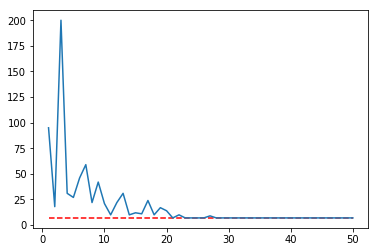

In [56]:
plotStep(stepsToGoal)

Running this a couple times, it seems like it spikes up highly at first and trys as many many moves as it can, then quickly settles back down near 7. More values for epsilon and learning rate will be tried, but first the Q dictionary will be tested.

In [57]:
path = testQ(Q, 20, validMoves, makeMove)

In [58]:
path

[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

Here we see the path returned by `testQ` is the optimal solution for towers of hanoi with three disks. The length of `path` is 8 because it includes the starting state, the solution only requires 7 moves. Lets print out the precesion here. 

In [61]:
for s in path:
    printState(s)
    print()

1    
2    
3    
-----

     
2    
3   1
-----

     
     
3 2 1
-----

     
  1  
3 2  
-----

     
  1  
  2 3
-----

     
     
1 2 3
-----

     
    2
1   3
-----

    1
    2
    3
-----



## Experimenting with Q
This section tries out different values for `epsilonDecayRate`, `learningRate` and `nRepititions` to see how the affect the the outcome of Q. 

First we'll try out different epsilon decay rates. This uses a loop that tries each each value .1, .2 ... .9 for epsilon. 

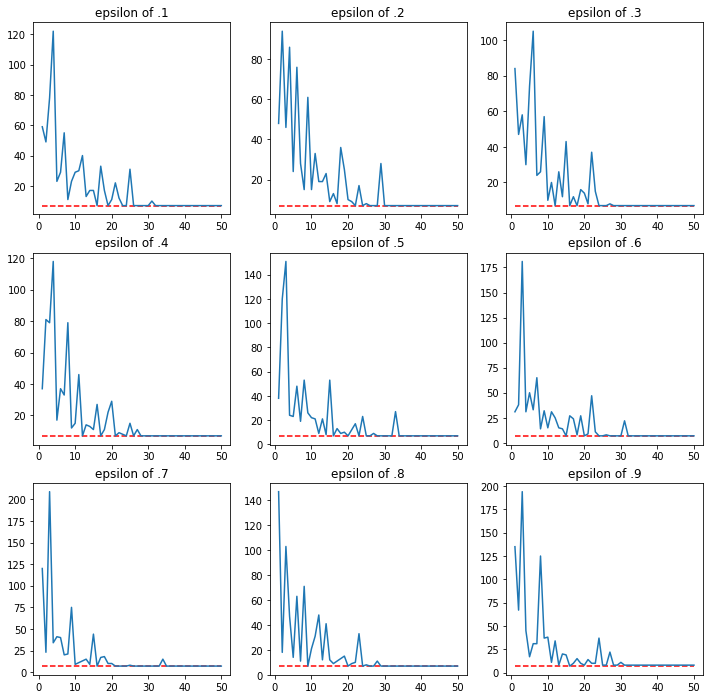

In [77]:
import numpy as np
results = []
for epsilonDecayRate in np.linspace(0.1, 0.9, 9 ):
    results.append(trainQ(50, 0.5, epsilonDecayRate, validMoves, makeMove))
fig = plt.figure(figsize = (12, 12))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    plotStep(results[i - 1][1])
    plt.title("epsilon of ." + str(i))
#plt.subplots_adjust(wspace = )

Now, the same thing but with learning rate!

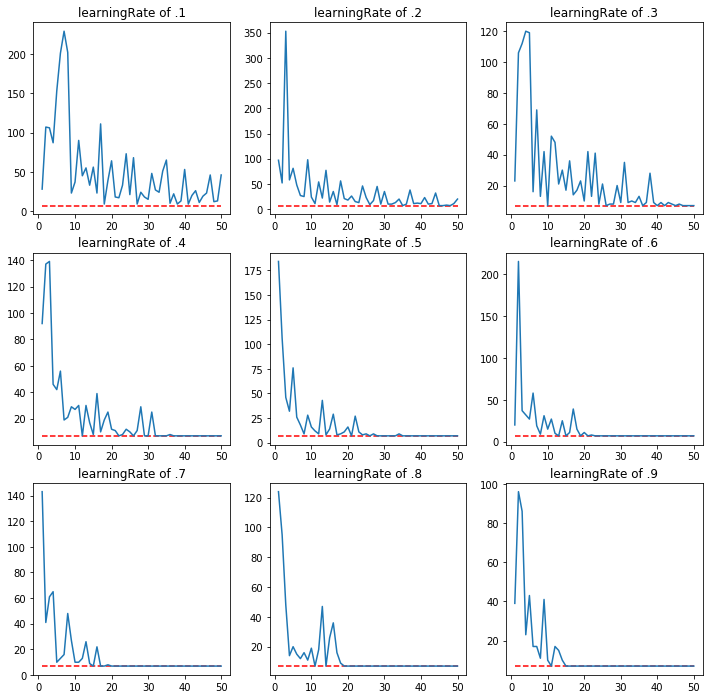

In [78]:
results = []
for learningRate in np.linspace(0.1, 0.9, 9 ):
    results.append(trainQ(50, learningRate, .7, validMoves, makeMove))
fig = plt.figure(figsize = (12, 12))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    plotStep(results[i - 1][1])
    plt.title("learningRate of ." + str(i))

Quick thoughts. Seems like epsilon rate doesn't really make a big difference. This is probably because of what was discussed in the piazza post about how `epsilonGreed` actually encourages taking the unseen move. So either way it tries out stuff it hasn't seen. Learning rate is cool to see though!

## Grading

Download and extract `A4grader.py` from [A4grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A4grader.tar).

In [79]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Newell-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing validMoves([[1], [2], [3]])

--- 10/10 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing validMoves([[], [], [1, 2, 3]])

--- 10/10 points. Correctly returned [[3, 1], [3, 2]]

Testing makeMove([[], [], [1, 2, 3]], [3, 2])

--- 10/10 points. Correctly returned [[], [1], [2, 3]]

Testing makeMove([[2], [3], [1]], [1, 2])

--- 10/10 points. Correctly returned [[], [2, 3], [1]]

Testing   Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove).

--- 10/10 points. Q dictionary has correct number of entries.

--- 10/10 points. The mean of the number of steps of 7.597 is correctly < 10.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 8, which is correctly less than 10.

cs440 Exec

<Figure size 432x288 with 0 Axes>

## Extra Credit

Modify your code to solve the Towers of Hanoi puzzle with 4 disks instead of 3.  Name your functions

    - printState_4disk
    - validMoves_4disk
    - makeMove_4disk

Find values for number of repetitions, learning rate, and epsilon decay factor for which trainQ learns a Q function that testQ can use to find the shortest solution path.  Include the output from the successful calls to trainQ and testQ.